In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import shap


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, recall_score
from sklearn.metrics import precision_score
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix  
import glob
from sklearn.model_selection import GridSearchCV


In [3]:
def string_to_float(string):
    return float(string.strip('[]'))


In [4]:
#file_path = "/lustrehome/mbossa/Nuses/Analysis/CaloPara_e-20000MeV.csv"
#file_path_proton = "/lustrehome/mbossa/Nuses/Analysis/CaloPara_proton20000MeV.csv"
file_path = "/lustrehome/mbossa/Nuses/Analysis/CaloParam_e-_inclined20000.0MeV.parquet"
file_path_proton = "/lustrehome/mbossa/Nuses/Analysis/CaloParam_proton_inclined20000.0MeV.parquet"

In [5]:
df_e = pd.read_csv(file_path)
df_p = pd.read_csv(file_path_proton)

In [6]:
df_e['R1'] = df_e['R1'].apply(string_to_float)
df_e['R2'] = df_e['R2'].apply(string_to_float)
df_e['R4'] = df_e['R4'].apply(string_to_float)
df_e['R5'] = df_e['R5'].apply(string_to_float)
df_e['R6'] = df_e['R6'].apply(string_to_float)

df_p['R1'] = df_p['R1'].apply(string_to_float)
df_p['R2'] = df_p['R2'].apply(string_to_float)
df_p['R4'] = df_p['R4'].apply(string_to_float)
df_p['R5'] = df_p['R5'].apply(string_to_float)
df_p['R6'] = df_p['R6'].apply(string_to_float)


In [7]:
df_e['R3'] = df_e['R3'].apply(lambda x: eval(x) if isinstance(x, str) else np.nan)
df_p['R3'] = df_p['R3'].apply(lambda x: eval(x) if isinstance(x, str) else np.nan)

In [8]:
for i in range(25):
        df_e[f'R3_{i+1}'] = df_e['R3'].apply(lambda x: x[i] if isinstance(x, list) and i < len(x) else 0)
df2 = df_e.drop(columns=['R3'])

In [9]:
for i in range(25):
        df_p[f'R3_{i+1}'] = df_p['R3'].apply(lambda x: x[i] if isinstance(x, list) and i < len(x) else 0)
df2_p = df_p.drop(columns=['R3'])

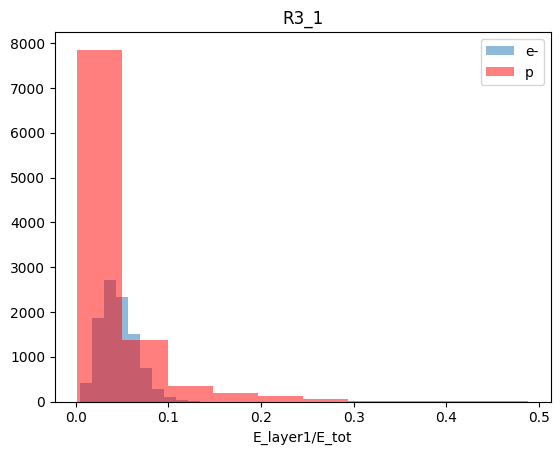

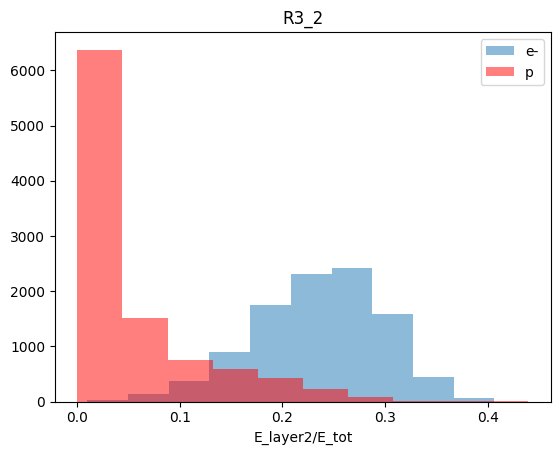

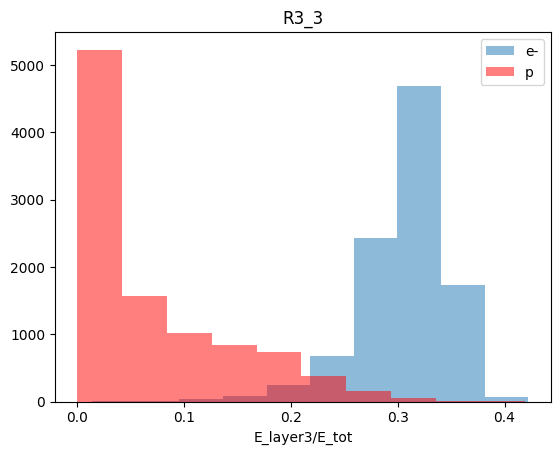

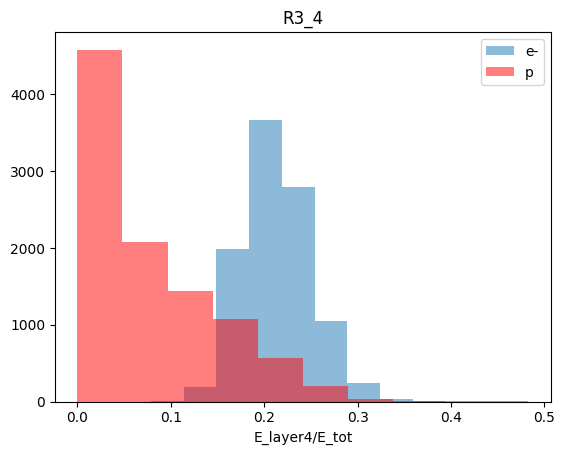

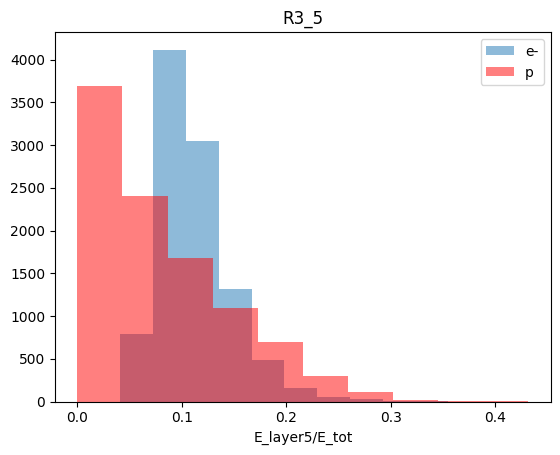

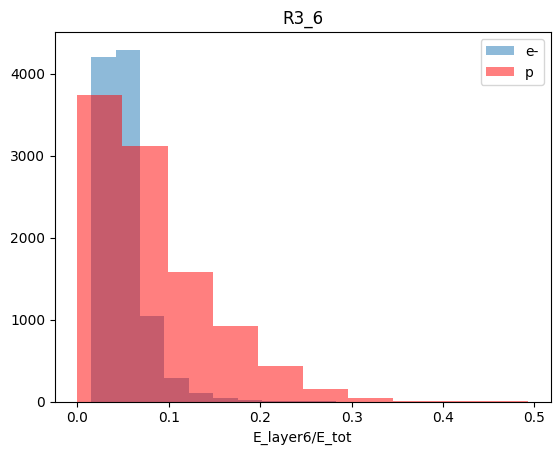

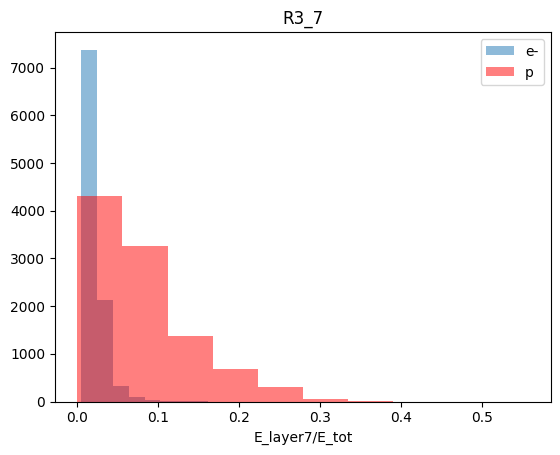

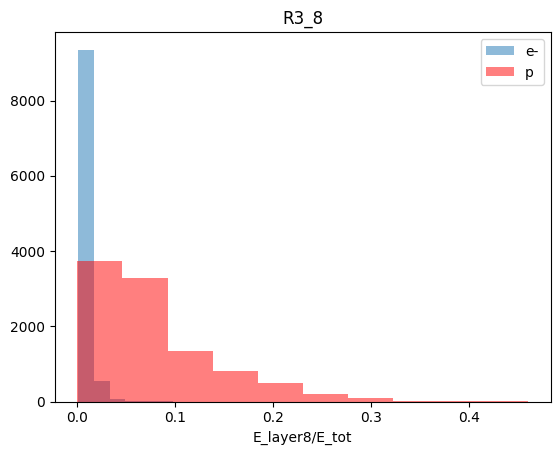

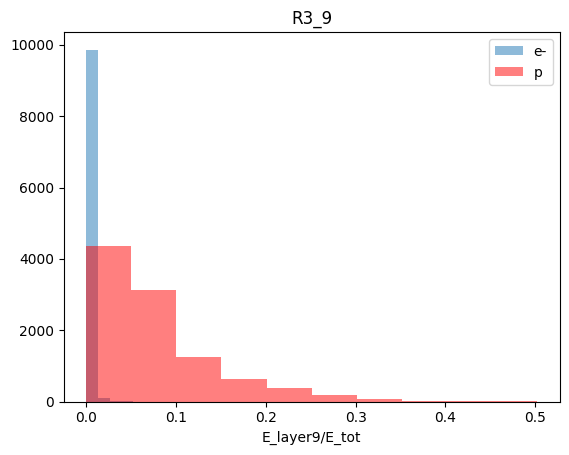

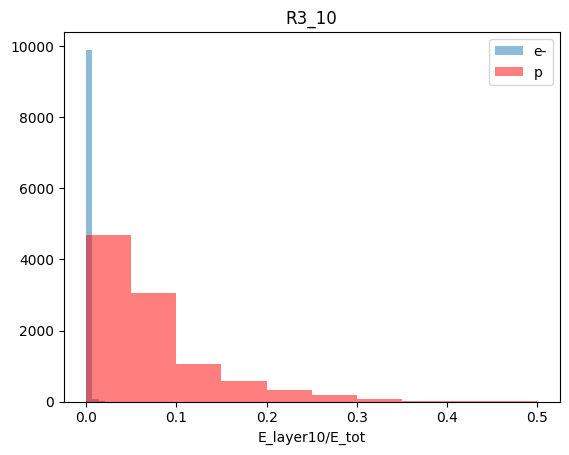

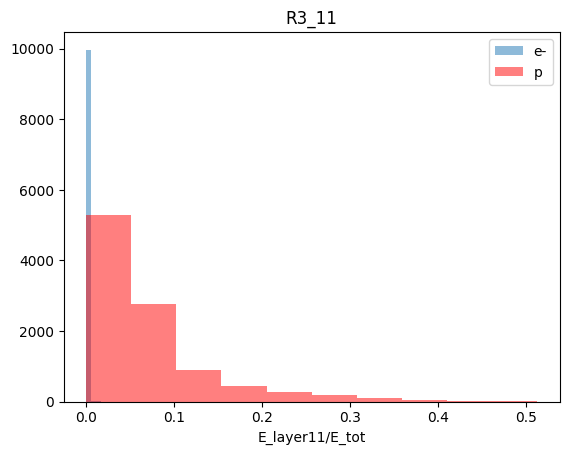

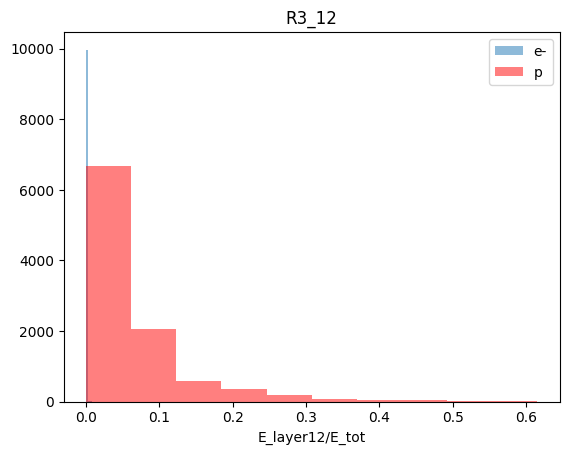

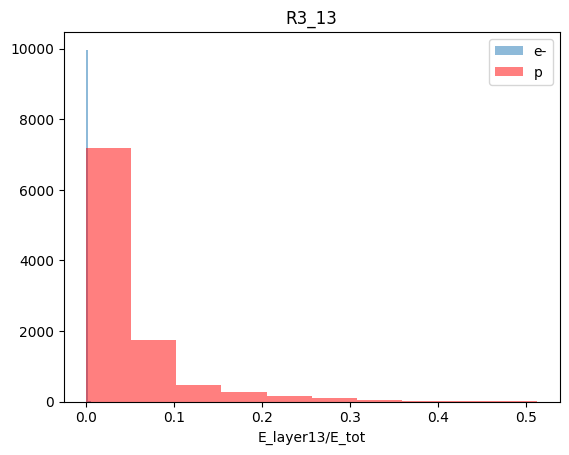

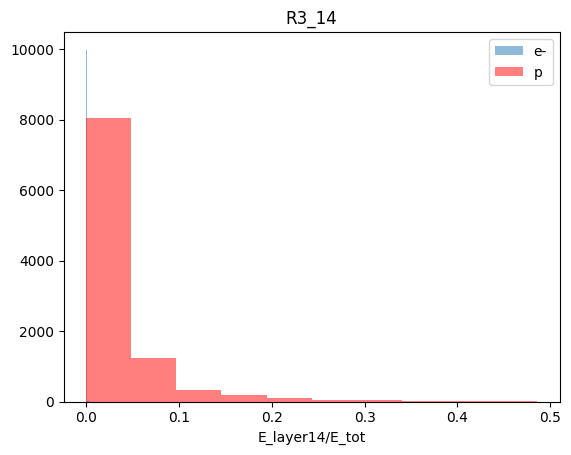

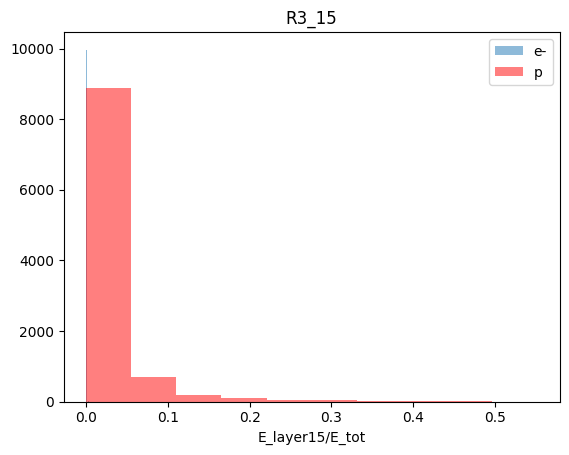

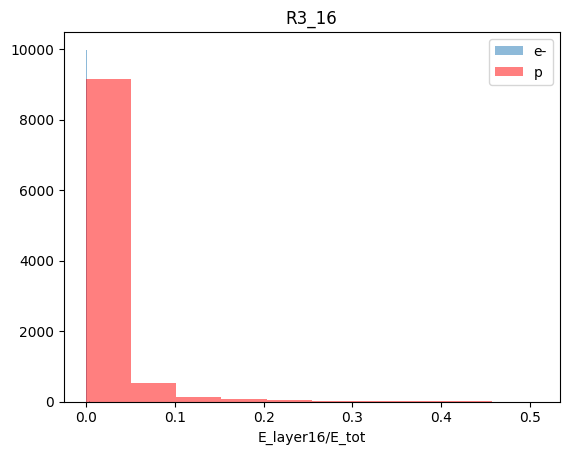

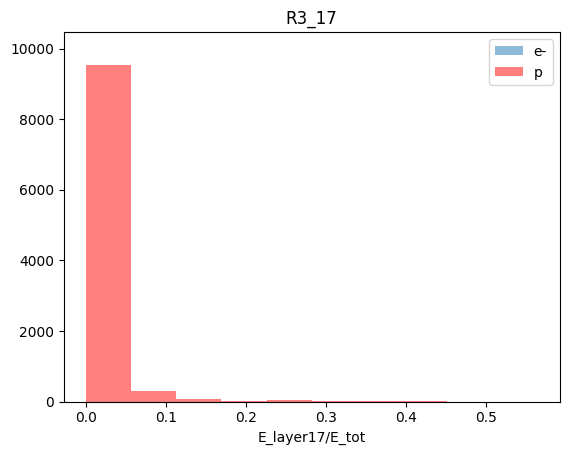

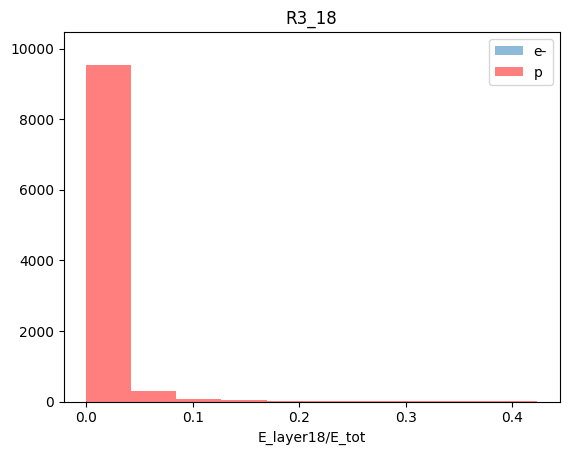

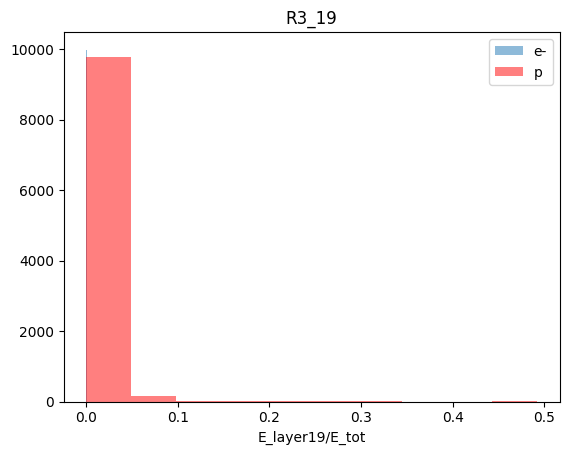

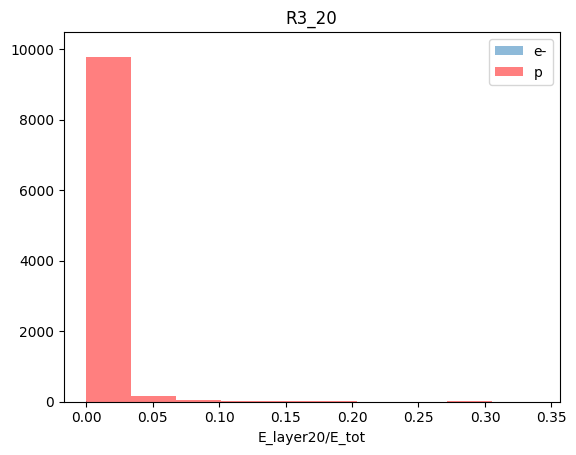

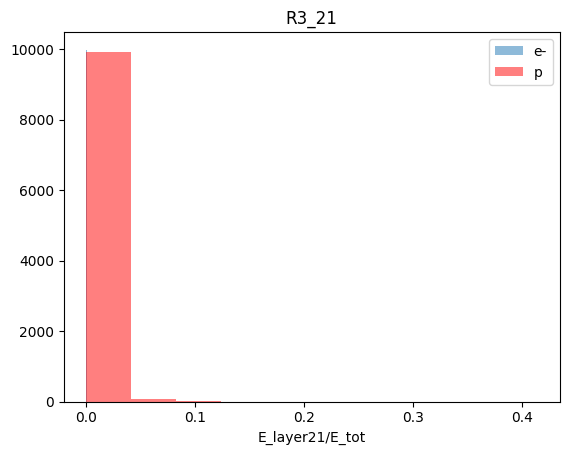

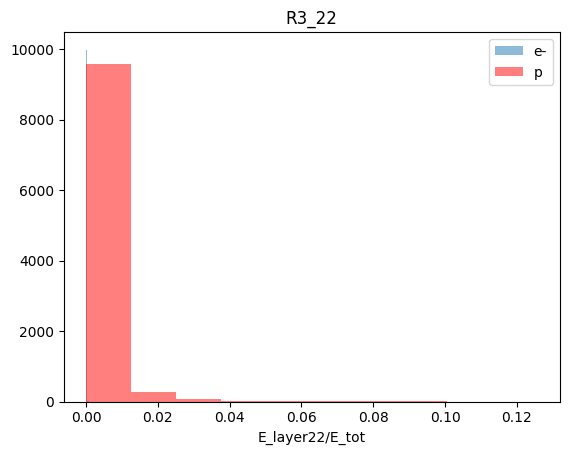

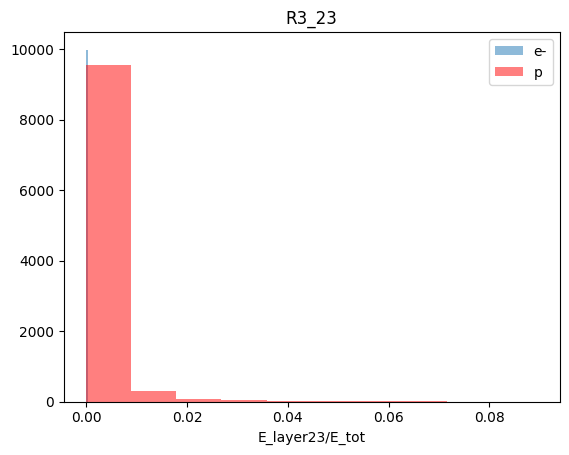

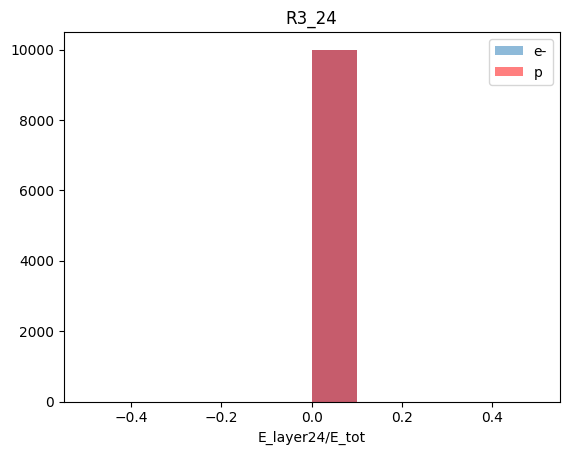

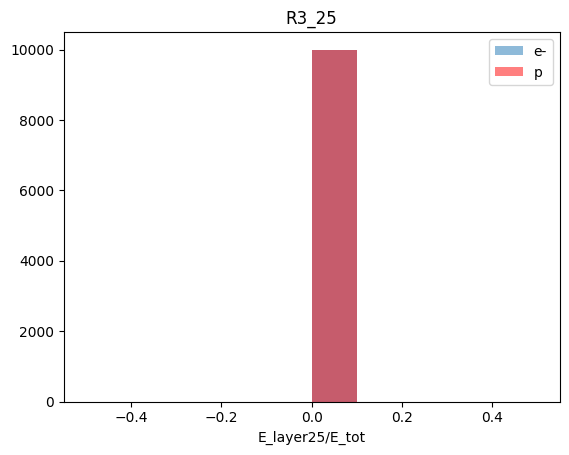

In [10]:
col=['R3_1', 'R3_2', 'R3_3', 'R3_4',
       'R3_5', 'R3_6', 'R3_7', 'R3_8', 'R3_9', 'R3_10', 'R3_11', 'R3_12',
       'R3_13', 'R3_14', 'R3_15', 'R3_16', 'R3_17', 'R3_18', 'R3_19', 'R3_20',
       'R3_21', 'R3_22', 'R3_23', 'R3_24', 'R3_25']
for i in col:
    try:
        #num_bins = max(len(df2[i]), len(df2_p[i]))
        num_bins = 10
        plt.hist(df2[i], bins=num_bins, alpha=0.5, label='e-')
        plt.hist(df2_p[i], bins=num_bins, color='red', alpha=0.5, label='p')
        
        #plt.hist(df2[i])
        #plt.hist(df2_p[i],color='red',alpha=0.5)
        #plt.hist(df_e_new[i])
        #plt.hist(df_p_new[i],color='orange',alpha=0.5)
        plt.xlabel("E_layer{}/E_tot".format(i.split('_')[1]))  # Imposta l'etichetta dell'asse x
        plt.title(f'{i}')
        plt.legend()
        #plt.show(block=False)
        plt.savefig(f'{i}'.format(i))
        plt.show()       
    except:
        print('col ', i)

In [10]:
df2['y_true'] = 0
df2_p['y_true'] = 1

In [11]:
combined_df = pd.concat([df2, df2_p])
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
y_true = shuffled_df['y_true'].values

In [12]:
param_grid_rf = {
    'n_estimators': [10],# 100, 150],  
    'max_depth': [7], #5, #3],
    'min_samples_split': [5],# 2, 10],  
    'min_samples_leaf': [4],# 2, 1],
}

rf_model = RandomForestClassifier(n_estimators= 10, criterion="entropy")  # Creazione del modello RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(shuffled_df.iloc[:, 1:-1], shuffled_df.iloc[:, -1], test_size=0.2, random_state=0)
st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
X_test= st_x.transform(X_test)    
rf_model.fit(X_train, y_train)  
#grid_search.fit(X_train, y_train)
#best_model = grid_search.best_estimator_

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [13]:
y_pred= rf_model.predict(X_test)  

In [14]:
cm = confusion_matrix(y_test, y_pred)

In [15]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


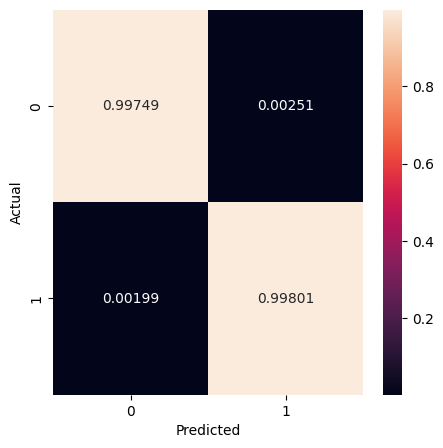

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.5f')#,xticklabels='electorn', yticklabels='proton')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

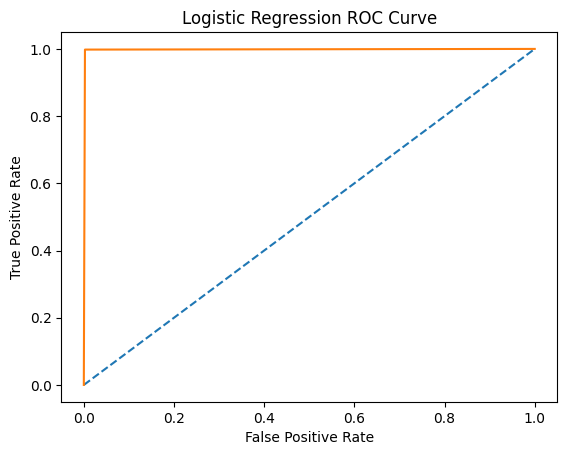

ROC Accuracy:  0.9977489639834237


In [17]:
y_true=shuffled_df.y_true.values
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot([0,1], [0,1], '--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Logistic Regression ROC Curve')
plt.show()
print("ROC Accuracy: ", roc_auc_score(y_test, y_pred))


In [18]:
#y_pred = best_model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy_rf = accuracy_score(y_test, predictions)
recall_rf = recall_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)

print("Accuracy Random Forest Classifier: %.2f%%" % (accuracy_rf * 100.0))
print("Recall Random Forest Classifier: %.2f%%" % (recall_rf * 100.0))
print("Precision Random Forest Classifier: %.2f%%" % (precision_rf * 100.0))


Accuracy Random Forest Classifier: 99.78%
Recall Random Forest Classifier: 99.80%
Precision Random Forest Classifier: 99.75%


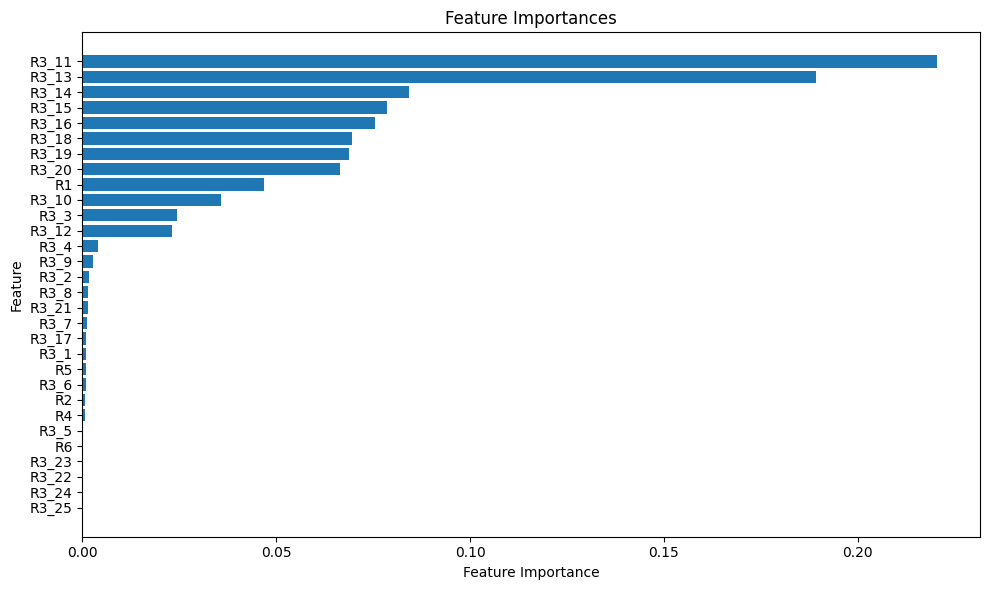

In [19]:
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': rf_model.feature_importances_,
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    #fig = px.bar(
    #    feature_importance_df,
    #    text_auto = '.2f',
    #    labels = {'value': 'feature importance'},
    #    title = 'Feature importances'
    #)

    #fig.update_layout(showlegend = False)
    #fig.show()
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df.index, feature_importance_df['feature_importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.tight_layout()

    plt.gca().invert_yaxis()  # Inverti l'asse y per rendere la feature più importante in alto
    plt.show()

plot_feature_importance(rf_model, list(shuffled_df.columns[1:-1]))

In [20]:
explainer = shap.Explainer(rf_model, X_train)
explainer = shap.TreeExplainer(rf_model, check_additivity=False)

In [21]:
X_train = pd.DataFrame(shuffled_df.iloc[:, 1:-1])
X_test = pd.DataFrame(shuffled_df.iloc[:, 1:-1])

In [22]:
shap_values = explainer.shap_values(X_test)


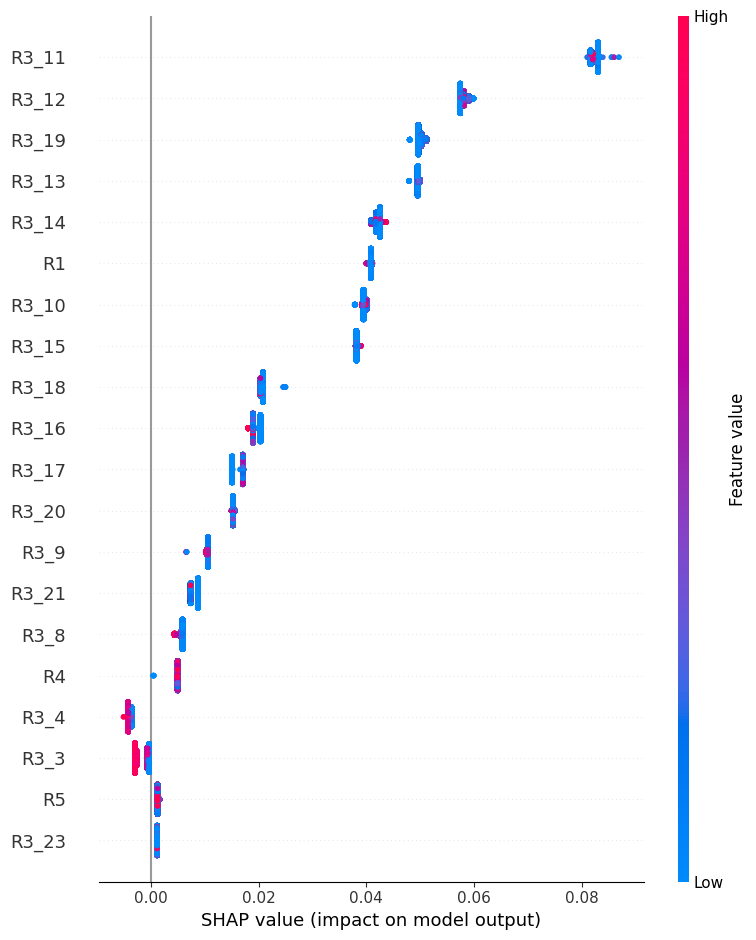

In [23]:
#shap.plots.beeswarm(shap_values, X_test, show=False)
fig = shap.summary_plot(shap_values[1], X_test, show=False)
plt.savefig('XAI_RF.png')

In [13]:
#xgb classifier
param_grid_xgb = {
    'max_depth': [3],#, 5, 7],
    'learning_rate': [0.1],# 0.01, 0.001],
    'subsample': [0.5],# 0.7, 1],
    'reg_alpha':[0],# 0.5, 1, 5],
    'reg_lambda':[0],# 0.5, 1, 5]   
}

xgb_model = xgb.XGBClassifier(tree_method="hist",seed=0)
grid_search = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy',refit=True)
# Fit the GridSearchCV object to the training data
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.iloc[:, 1:-1], shuffled_df.iloc[:, -1], test_size=0.3, random_state=0)
X_val, X_test1, Y_val, Y_test1 = train_test_split(X_test, y_test, test_size=0.1, random_state=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [14]:
y_pred = best_model.predict(X_test)
predictions_xgb = [round(value) for value in y_pred]
# evaluate predictions
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
recall_xgb = recall_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred)

print("Accuracy XGB Classifier: %.2f%%" % (accuracy_xgb * 100.0))
print("Recall XGB Classifier: %.2f%%" % (recall_xgb * 100.0))
print("Precision XGB Classifier: %.2f%%" % (precision_xgb * 100.0))


Accuracy XGB Classifier: 99.73%
Recall XGB Classifier: 99.73%
Precision XGB Classifier: 99.73%


[0]	validation_0-logloss:0.59897	validation_1-logloss:0.59911
[1]	validation_0-logloss:0.52186	validation_1-logloss:0.52226
[2]	validation_0-logloss:0.45741	validation_1-logloss:0.45803
[3]	validation_0-logloss:0.40303	validation_1-logloss:0.40391
[4]	validation_0-logloss:0.35652	validation_1-logloss:0.35758
[5]	validation_0-logloss:0.31648	validation_1-logloss:0.31774
[6]	validation_0-logloss:0.28179	validation_1-logloss:0.28315
[7]	validation_0-logloss:0.25156	validation_1-logloss:0.25289
[8]	validation_0-logloss:0.22505	validation_1-logloss:0.22644
[9]	validation_0-logloss:0.20163	validation_1-logloss:0.20330
[10]	validation_0-logloss:0.18104	validation_1-logloss:0.18277
[11]	validation_0-logloss:0.16281	validation_1-logloss:0.16465
[12]	validation_0-logloss:0.14651	validation_1-logloss:0.14853
[13]	validation_0-logloss:0.13205	validation_1-logloss:0.13434
[14]	validation_0-logloss:0.11908	validation_1-logloss:0.12156
[15]	validation_0-logloss:0.10756	validation_1-logloss:0.11026
[1

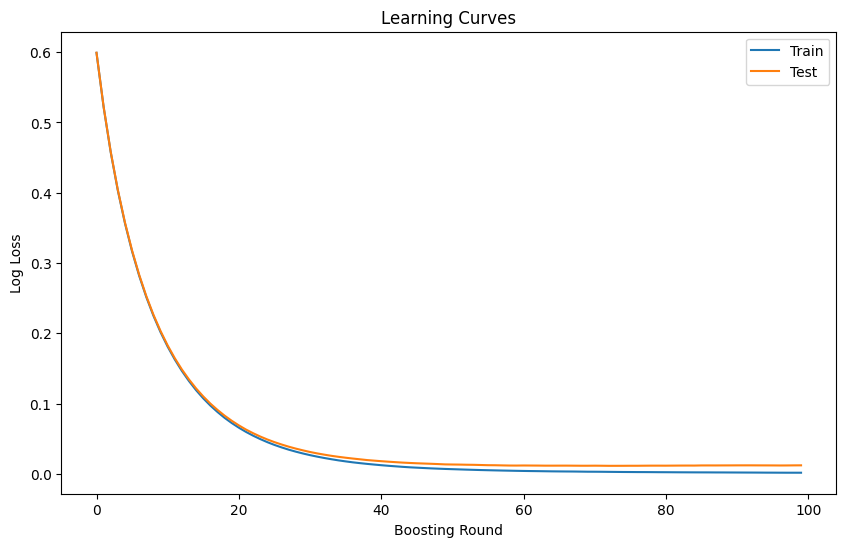

In [17]:
#eval_set = [(X_train, y_train), (X_test, y_test)]
eval_set = [(X_train, y_train), (X_val, Y_val)]

# Addestra il modello con il set di valutazione
best_model.fit(X_train, y_train, eval_metric='logloss', eval_set=eval_set, verbose=True)
# Recupera i risultati della valutazione
results = best_model.evals_result()

# Visualizza le curve di apprendimento
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [21]:
dtrain = xgb.DMatrix(X_train, label=y_train)
train_scores = []

# Numero di iterazioni di addestramento
num_rounds = 100

# Addestra il modello iterativamente
for i in range(num_rounds):
    # Addestra il modello
    bst = xgb.train(best_model, dtrain, num_boost_round=i+1)
    
    # Calcola il punteggio di addestramento
    train_pred = bst.predict(dtrain)
    train_accuracy = np.mean((train_pred > 0.5) == y_train)
    
    # Aggiungi il punteggio di addestramento all'elenco
    train_scores.append(train_accuracy)

AttributeError: 'XGBClassifier' object has no attribute 'copy'

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_rounds + 1), train_scores, label='Train')
plt.xlabel('Number of Rounds')
plt.ylabel('Training Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'num_rounds' is not defined

<Figure size 1000x600 with 0 Axes>

In [53]:
cv_results = grid_search.cv_results_
print(cv_results.keys())
# Estrai la media della perdita (logloss) su ciascuna fold della cross-validation
mean_train_logloss = cv_results['mean_train_score']
mean_test_logloss = cv_results['mean_test_score']

# Plot della perdita (logloss) media su train set e test set
plt.plot(mean_train_logloss, label='train')
plt.plot(mean_test_logloss, label='test')
plt.xlabel('Number of iterations')
plt.ylabel('Mean Logloss')
plt.title('Mean Logloss over iterations')
plt.legend()
plt.show()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_reg_alpha', 'param_reg_lambda', 'param_subsample', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


KeyError: 'mean_train_score'

In [24]:
best_learning_rate = grid_search.best_params_['learning_rate']
print("Best Learning Rate XGB:", best_learning_rate)

Best Learning Rate XGB: 0.1


In [16]:
explainer = shap.Explainer(best_model, X_train)
explainer = shap.TreeExplainer(best_model, check_additivity=False)

In [17]:
X_train = pd.DataFrame(shuffled_df.iloc[:, 1:-1])
X_test = pd.DataFrame(shuffled_df.iloc[:, 1:-1])

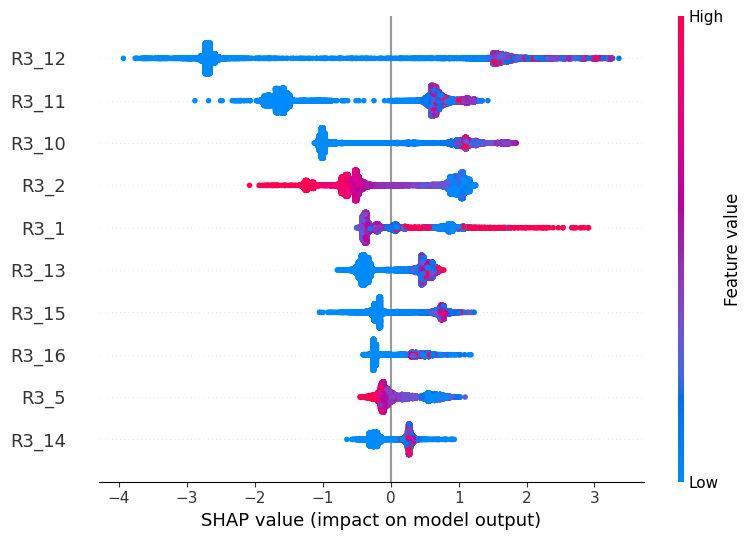

In [18]:
shap_values = explainer.shap_values(X_test)
fig = shap.summary_plot(shap_values, X_test, show=False, max_display=10)
plt.savefig('XAI_XGB_prova2.png')

In [29]:
#feature_names = shuffled_df.columns[1:-1]
#feature_names

Index(['R1', 'R2', 'R4', 'R5', 'R6', 'R3_1', 'R3_2', 'R3_3', 'R3_4', 'R3_5',
       'R3_6', 'R3_7', 'R3_8', 'R3_9', 'R3_10', 'R3_11', 'R3_12', 'R3_13',
       'R3_14', 'R3_15', 'R3_16', 'R3_17', 'R3_18', 'R3_19', 'R3_20', 'R3_21',
       'R3_22', 'R3_23', 'R3_24', 'R3_25'],
      dtype='object')

In [30]:
#X_test_values = shuffled_df.iloc[:, 1:-1].values
#X_train_values = shuffled_df.iloc[:, 1:-1]
#X_train = pd.DataFrame(shuffled_df.iloc[:, 1:-1])


In [21]:
abs(shap_values).mean(0)

array([0.26521337, 0.30070215, 0.16891055, 0.26114728, 0.13764497,
       0.21955972, 0.99219413, 0.93117238, 0.77634503, 0.22379204,
       0.10633658, 0.169067  , 0.1208682 , 0.1786769 , 0.51943989,
       0.89843128, 0.85471077, 0.28277394, 0.33687707, 0.51579327,
       0.61671661, 0.65092925, 0.3966972 , 0.06745041, 0.28718955,
       0.16927895, 0.2840234 , 0.45928939, 0.        , 0.        ])

 99%|===================| 19870/20000 [00:30<00:00]        

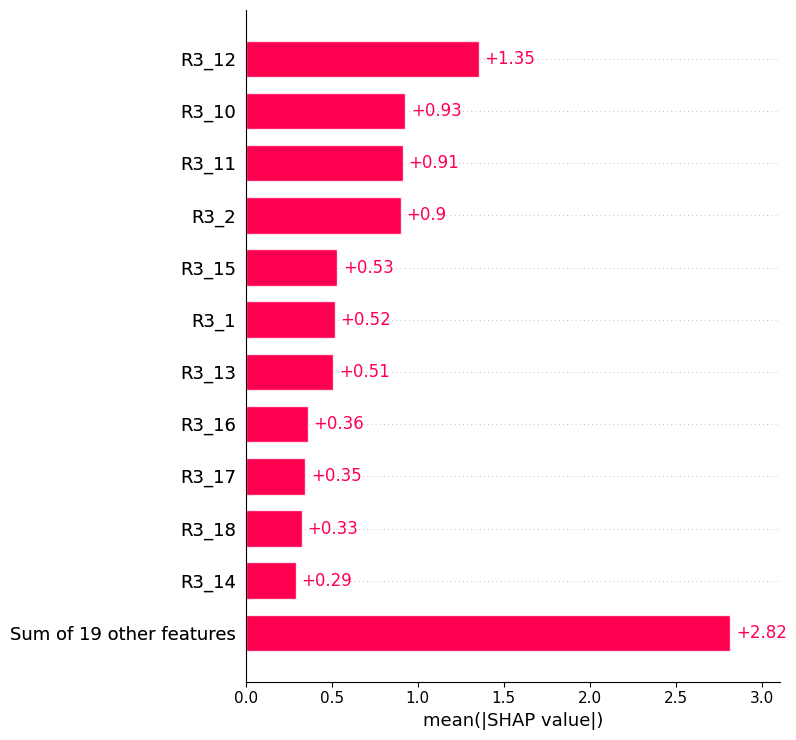

In [20]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
#shap.plots.bar(shap_values.mean(0), max_display=12, show=False)
shap.plots.bar(shap_values.abs.mean(0), max_display=12, show=False)
#plt.show()

#plt.gcf()
plt.tight_layout()
plt.savefig('plots_bar.png')#, bbox_inches='tight')

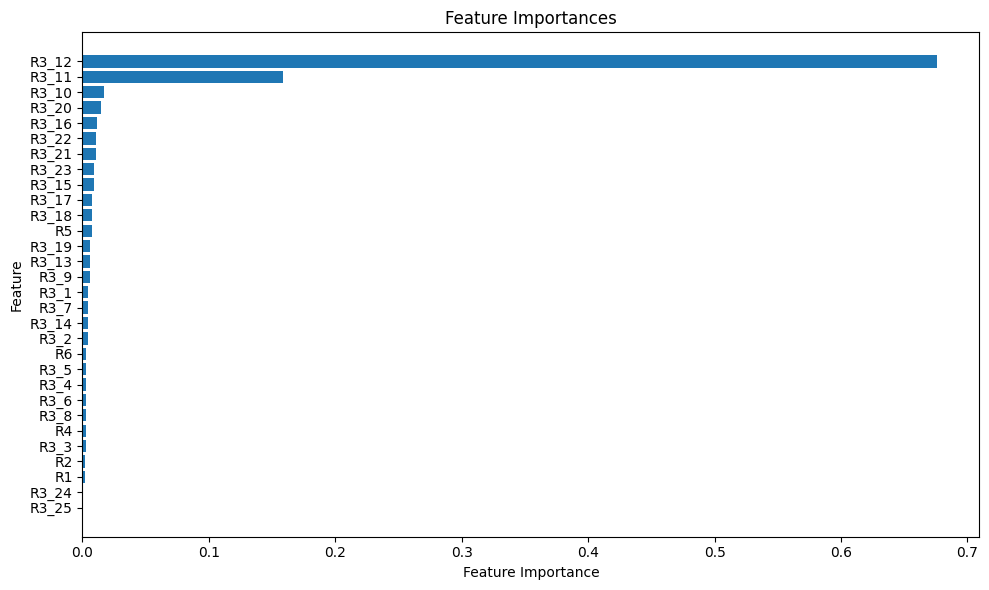

In [19]:
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': best_model.feature_importances_,
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    #fig = px.bar(
    #    feature_importance_df,
    #    text_auto = '.2f',
    #    labels = {'value': 'feature importance'},
    #    title = 'Feature importances'
    #)

    #fig.update_layout(showlegend = False)
    #fig.show()
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df.index, feature_importance_df['feature_importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.tight_layout()

    plt.gca().invert_yaxis()  # Inverti l'asse y per rendere la feature più importante in alto
    plt.show()

plot_feature_importance(best_model, list(shuffled_df.columns[1:-1]))

In [32]:
conf_matrix_xgb = confusion_matrix(y_test, predictions_xgb, normalize='true')


In [33]:
print("Confusion Matrix XGB Classifier:")
print(conf_matrix_xgb)

Confusion Matrix XGB Classifier:
[[9.99498747e-01 5.01253133e-04]
 [1.49625935e-03 9.98503741e-01]]


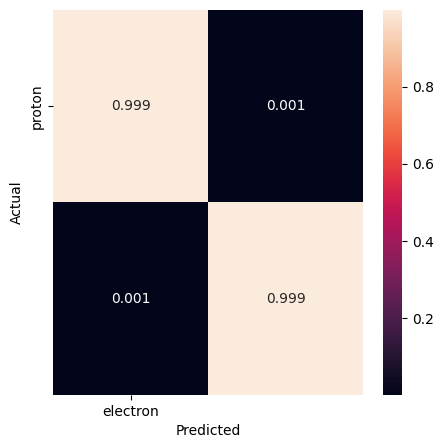

In [34]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='.3f',xticklabels=['electron'], yticklabels=['proton'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.show(block=False)
plt.savefig('Confusion_matrix_XGB')

In [30]:
conf_matrix_normalized_xgb = conf_matrix_xgb.astype('float') / conf_matrix_xgb.sum(axis=1)[:, np.newaxis]

In [31]:
print("Confusion Matrix XGB Classifier:")
print(conf_matrix_normalized_xgb)

Confusion Matrix XGB Classifier:
[[0.998998   0.001002  ]
 [0.00249501 0.99750499]]


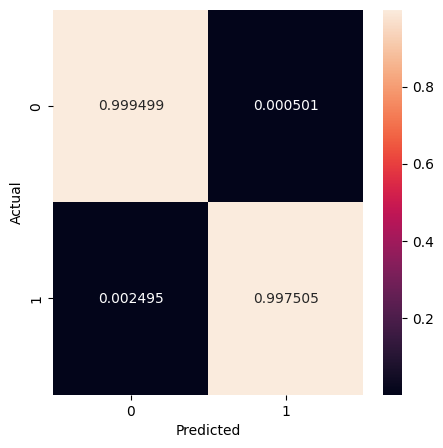

In [33]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.6f')#,xticklabels='electorn', yticklabels='proton')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)